In [2]:
# Import widgets for interactive threshold controls
import pandas as pd
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import numpy as np
import spectral as sp
import pandas as pd
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt
# import cv2
import math
import os
from sklearn.preprocessing import MinMaxScaler
import copy
import pickle
import warnings
# import seaborn as sns
from Lamewarden_tools.HS_tools.readHS import *
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from scipy.signal import savgol_filter
from sklearn.preprocessing import label_binarize
import datetime
plt.rcParams['axes.grid'] = False
# Ignore RuntimeWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
from sklearn.utils import resample
# supplement functions
from imblearn.over_sampling import SMOTE
from scipy.ndimage import gaussian_filter1d
import numpy as np
import copy

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('spectral').setLevel(logging.CRITICAL)

# Features Extraction + Machine Learning

## Preprocessed data loading

In [6]:
df = pd.read_csv(r'data/extracted_spectra.csv')
df.sample(5)

,347,348,349,350,352,353,354,355,356,357,...,890,891,892,894,895,896,897,898,899,label
13189,0.079645,0.079432,0.079026,0.078461,0.077786,0.077055,0.076322,0.075633,0.075022,0.074506,...,1.156545,1.153919,1.151196,1.148465,1.145850,1.143499,1.141564,1.140184,1.139464,L15
21582,0.298374,0.298211,0.297857,0.297251,0.296316,0.294949,0.293038,0.290467,0.287124,0.282910,...,1.564442,1.569115,1.573138,1.576463,1.579082,1.581040,1.582405,1.583257,1.583664,L4
14767,0.045133,0.045224,0.045401,0.045660,0.045990,0.046381,0.046818,0.047281,0.047752,0.048207,...,1.025249,1.022713,1.020236,1.017869,1.015682,1.013764,1.012214,1.011119,1.010552,L15
6951,0.125992,0.126054,0.126185,0.126397,0.126702,0.127107,0.127606,0.128181,0.128789,0.129369,...,1.076664,1.074481,1.072189,1.069875,1.067651,1.065649,1.064001,1.062825,1.062213,L15
10826,0.139314,0.139177,0.138886,0.138405,0.137689,0.136681,0.135323,0.133557,0.131333,0.128612,...,1.129212,1.128351,1.127531,1.126764,1.126067,1.125463,1.124979,1.124640,1.124464,L26


In [7]:
# Cutting edges of the spectra (to remove excessive sensor noise)
labels = df['label']
df = df.iloc[:, 30:-30]
df['label'] = labels


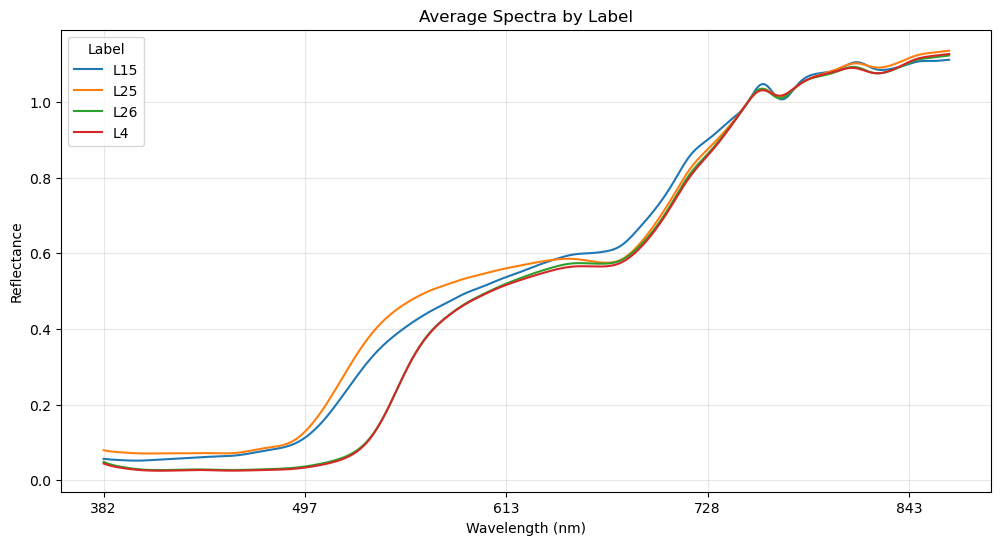

In [8]:
df.groupby('label').mean().T.plot(figsize=(12, 6))
plt.title('Average Spectra by Label')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True, alpha=0.3)
plt.legend(title='Label')
plt.show()

# ML (will go into separate notebook)

In [9]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, cohen_kappa_score, classification_report,
                             confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import os
import datetime
import json


def upsample_data(X, y, method='random', random_state=42):
    """
    Upsample training data.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Feature matrix.
    y : array-like of shape (n_samples,)
        Labels/targets.
    method : str, optional (default='random')
        Method to use for upsampling. Options:
            - 'random': Random oversampling to match the largest class size.
            - 'smote': SMOTE oversampling.
    random_state : int, optional (default=42)
        Random seed for reproducibility.
        
    Returns
    -------
    X_resampled : ndarray of shape (n_samples_new, n_features)
        Upsampled feature matrix.
    y_resampled : ndarray of shape (n_samples_new,)
        Upsampled labels.
    """
    if method == 'random':
        # Convert to DataFrame for easy groupby/concat operations
        df_features = pd.DataFrame(X)
        df_labels = pd.Series(y, name='label')
        df_train = pd.concat([df_features, df_labels], axis=1)

        # Determine the max class size
        max_class_size = df_train['label'].value_counts().max()

        # Oversample each class to match max_class_size
        df_upsampled = pd.concat([
            resample(df_class,
                     replace=True,
                     n_samples=max_class_size,
                     random_state=random_state)
            for _, df_class in df_train.groupby('label')
        ])

        # Shuffle the upsampled data
        df_upsampled = df_upsampled.sample(frac=1, random_state=random_state)

        # Split back into X and y
        X_resampled = df_upsampled.drop('label', axis=1).values
        y_resampled = df_upsampled['label'].values
    
    elif method == 'smote':
        sm = SMOTE(random_state=random_state)
        X_resampled, y_resampled = sm.fit_resample(X, y)
    
    else:
        raise ValueError(f"Unsupported upsampling method: {method}. Use 'random' or 'smote'.")
    
    return X_resampled, y_resampled

def evaluate_and_store_metrics(y_test, y_pred, model_name, metrics_dict=None):
    """
    Calculates classification metrics, prints a classification report,
    and updates (or creates) a metrics dictionary.

    Args:
        y_test: True labels.
        y_pred: Predicted labels.
        model_name: Name of the model (used as key in metrics_dict).
        metrics_dict: (Optional) Existing metrics dictionary.  If None,
                      a new one is created.

    Returns:
        Updated metrics_dict.
    """

    if metrics_dict is None:
        metrics_dict = {}

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)

    # Print metrics
    print(f'{model_name} Classification Accuracy: {accuracy:.4f}')
    print(f'{model_name} Recall: {recall:.4f}')
    print(f'{model_name} Precision: {precision:.4f}')
    print(f'{model_name} F1-score (weighted): {f1:.4f}')
    print(f'{model_name} Cohen\'s Kappa: {kappa:.4f}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate per-class accuracy
    cm = confusion_matrix(y_test, y_pred)
    per_class_accuracy = {}
    class_names = np.unique(y_test)  # Get unique class names
    for i in range(cm.shape[0]):
         # Ensure no division by zero
        if np.sum(cm[i, :]) > 0:
           per_class_accuracy[str(class_names[i])] = cm[i, i] / np.sum(cm[i, :])
        else:
            per_class_accuracy[str(class_names[i])] = 0.0 # Or np.nan, or another suitable placeholder

    # Store metrics in the dictionary
    metrics_dict[model_name] = {
        'Accuracy': accuracy,
        'F1-score': f1,
        'Recall': recall,
        'Precision': precision,
        'Kappa': kappa,
        'Per-class Accuracy': per_class_accuracy,
        'y_test': y_test,
        'y_pred': y_pred
    }

    return metrics_dict

def upsample_data(X, y, method='random', random_state=42):
    """
    Upsample training data.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Feature matrix.
    y : array-like of shape (n_samples,)
        Labels/targets.
    method : str, optional (default='random')
        Method to use for upsampling. Options:
            - 'random': Random oversampling to match the largest class size.
            - 'smote': SMOTE oversampling.
    random_state : int, optional (default=42)
        Random seed for reproducibility.
        
    Returns
    -------
    X_resampled : ndarray of shape (n_samples_new, n_features)
        Upsampled feature matrix.
    y_resampled : ndarray of shape (n_samples_new,)
        Upsampled labels.
    """
    if method == 'random':
        # Convert to DataFrame for easy groupby/concat operations
        df_features = pd.DataFrame(X)
        df_labels = pd.Series(y, name='label')
        df_train = pd.concat([df_features, df_labels], axis=1)

        # Determine the max class size
        max_class_size = df_train['label'].value_counts().max()

        # Oversample each class to match max_class_size
        df_upsampled = pd.concat([
            resample(df_class,
                     replace=True,
                     n_samples=max_class_size,
                     random_state=random_state)
            for _, df_class in df_train.groupby('label')
        ])

        # Shuffle the upsampled data
        df_upsampled = df_upsampled.sample(frac=1, random_state=random_state)

        # Split back into X and y
        X_resampled = df_upsampled.drop('label', axis=1).values
        y_resampled = df_upsampled['label'].values
    
    elif method == 'smote':
        sm = SMOTE(random_state=random_state)
        X_resampled, y_resampled = sm.fit_resample(X, y)
    
    else:
        raise ValueError(f"Unsupported upsampling method: {method}. Use 'random' or 'smote'.")
    
    return X_resampled, y_resampled


def compute_classification_metrics(y_true, y_pred, average='weighted'):
    """
    Compute classification metrics (accuracy, precision, recall, f1).
    
    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        average (str, optional): Averaging method for multi-class
                                 precision, recall, f1. Defaults to 'weighted'.

    Returns:
        dict: A dictionary containing accuracy, precision, recall, and f1.
    """
    # Convert to numpy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    accuracy_val = round(accuracy_score(y_true, y_pred),4)
    precision_val = round(precision_score(y_true, y_pred, average=average),4)
    recall_val = round(recall_score(y_true, y_pred, average=average),4)
    f1_val = round(f1_score(y_true, y_pred, average=average),4)
    
    return {
        'accuracy': accuracy_val,
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1_val
    }

def plot_confusion_matrix(y_true, y_pred, class_names=None, fig_size=(8,6)):
    """
    Plot a confusion matrix with absolute counts and row-wise percentages.
    The percentage values are displayed in a smaller font.
    
    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        class_names (list, optional): List of class names (strings).
            If None, indices [0..n_classes-1] will be used.
        fig_size (tuple, optional): Figure size in inches. Default is (8, 6).
    """
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]

    # If no class names are provided, just use numeric class indices
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    
    # Compute row-wise percentages
    cm_percent = np.zeros_like(cm, dtype=float)
    for i in range(n_classes):
        row_sum = cm[i].sum()
        if row_sum != 0:
            cm_percent[i] = cm[i] / row_sum * 100
        else:
            cm_percent[i] = 0

    fig, ax = plt.subplots(figsize=fig_size)
    cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar(cax)

    # Set tick marks and labels
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Determine threshold for text color
    threshold = cm.max() / 2.

    # Loop over data dimensions and create text annotations.
    for i in range(n_classes):
        for j in range(n_classes):
            abs_val = cm[i, j]
            perc_val = cm_percent[i, j]
            color = 'white' if abs_val > threshold else 'black'
            # Place absolute count above center
            ax.text(j, i - 0.2, f"{abs_val}", ha='center', va='center', color=color, fontsize=12)
            # Place percentage value below center in a smaller font
            ax.text(j, i + 0.2, f"{perc_val:.1f}%", ha='center', va='center', color=color, fontsize=8)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def save_model(model, model_name, path, study=None):
    """
    Saves the given model to the specified path. The file name is prefixed with
    the current date (YYYY.MM.DD) and suffixed by `_model` or `_hp`.
    
    Parameters
    ----------
    model : scikit-learn estimator or torch.nn.Module
        The trained model to save.
    model_name : str
        A string identifying the model (e.g., "RandomForest", "ResNet").
    path : str
        The local directory where the model (and optional HP file) will be saved.
    study : optuna.study.Study, optional
        If provided, hyperparameters of the best trial will be saved as a JSON file.
    """
    # Lazy imports so the function doesn't break if the user does not have
    # both scikit-learn and PyTorch installed:
    try:
        import torch
    except ImportError:
        torch = None
    try:
        import joblib
    except ImportError:
        joblib = None

    # 1) Ensure directory exists
    os.makedirs(path, exist_ok=True)
    
    # 2) Create a date+name prefix for files
    date_str = datetime.now().strftime("%Y.%m.%d")
    base_file_name = f"{date_str}_{model_name}_model"
    
    # 3) Check if this is a PyTorch model or scikit-learn model
    if torch is not None and isinstance(model, torch.nn.Module):
        # Save as PyTorch .pth
        save_path = os.path.join(path, base_file_name + ".pth")
        torch.save(model.state_dict(), save_path)
    else:
        # Assume scikit-learn model; save as pickle
        if joblib is None:
            raise ImportError("joblib is required to save a scikit-learn model.")
        save_path = os.path.join(path, base_file_name + ".pkl")
        joblib.dump(model, save_path)

    print(f"Model saved to: {save_path}")

    # 4) If study is provided, save its best hyperparameters
    if study is not None:
        hp_file_name = base_file_name + "_hp.json"
        hp_path = os.path.join(path, hp_file_name)
        
        # Gather the best trial’s info
        hp_data = {
            "best_params": study.best_params,
            "best_value": study.best_value,
            "best_trial_number": study.best_trial.number
        }
        with open(hp_path, "w") as f:
            json.dump(hp_data, f, indent=4)

        print(f"Hyperparameters saved to: {hp_path}")

def vis_clust_2D(X, pc_to_visualize):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Map unique labels to integer values to color them
    unique_labels = X['label'].unique()
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    colors = X['label'].map(label_mapping)

    # Create a scatter plot, color by 'label' column values
    scatter = ax.scatter(x=X.iloc[:, pc_to_visualize[0]], y=X.iloc[:, pc_to_visualize[1]], c=colors, cmap='rainbow')

    # Create a legend with the actual 'label' values
    handles, _ = scatter.legend_elements()
    labels = [str(label) for label in unique_labels]
    ax.legend(handles=handles, labels=labels, title="Label")
    plt.xlabel(f'PC{pc_to_visualize[0]}')
    plt.ylabel(f'PC{pc_to_visualize[1]}')

    # Show the plot
    plt.show()

[I 2025-08-16 12:33:24,369] A new study created in memory with name: no-name-2ff11024-09d0-407c-a24a-02e180579495


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-08-16 12:33:31,924] Trial 0 finished with value: 0.8932099130537647 and parameters: {'n_components': 30, 'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8932099130537647.
[I 2025-08-16 12:33:36,924] Trial 3 finished with value: 0.6601723152146054 and parameters: {'n_components': 10, 'n_estimators': 175, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8932099130537647.
[I 2025-08-16 12:33:40,407] Trial 1 finished with value: 0.6852822302399401 and parameters: {'n_components': 20, 'n_estimators': 225, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8932099130537647.
[I 2025-08-16 12:33:40,440] Trial 2 finished with value: 0.9070247037716135 and parameters: {'n_components': 30, 'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9070247037716135.
[I 2025-08-16 12:

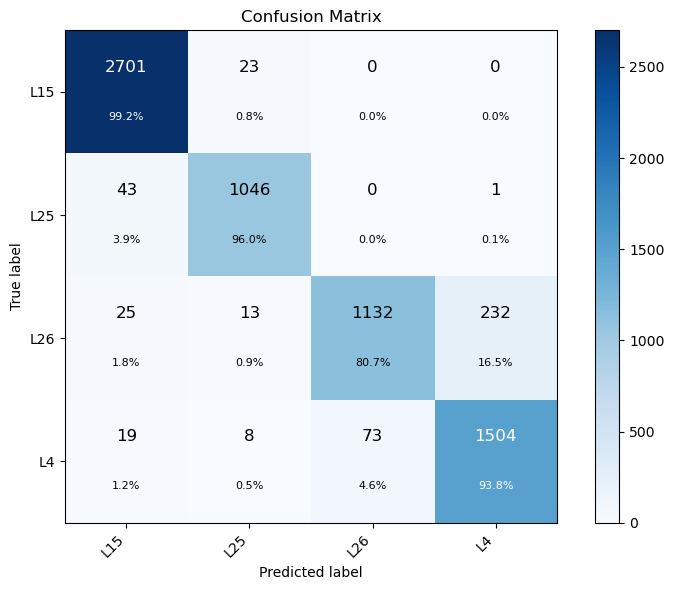

Model saved to: suppl_files\models\2025.06\HSI\RF/2025.08.16_RF_PCA_class_model.pkl
Hyperparameters saved to: suppl_files\models\2025.06\HSI\RF/2025.08.16_RF_PCA_class_model_hp.json


In [14]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna
from optuna.samplers import TPESampler
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import os



df.columns = df.columns.map(lambda x: int(x) if str(x).isdigit() else x)



# Prepare features and labels
X = df.iloc[:,:-1].values
y = df['label'].values

# Split randomly instead
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,  # Adjust test size as needed
    random_state=42, 
    stratify=y  # Ensures balanced distribution of labels in train/test
)
# creating smaller X_train / y_train to speed up hyperparameters tuning
X_train_hp = X_train[::10, :]  # taking every 10th sample for faster tuning
y_train_hp = y_train[::10]  # taking every 10th sample for faster tuning


n_jobs = 4


# ============================
# 1) Define the objective for Optuna
# ============================
def objective(trial):
    # PCA hyperparameter
    n_components = trial.suggest_categorical('n_components', [10, 20, 30, 40])
    
    # RandomForest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=25)
    max_depth = trial.suggest_int('max_depth', 2, 10, step=2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Build pipeline: PCA -> RF
    pipeline = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('rf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=n_jobs
        ))
    ])

    # Use 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train_hp, y_train_hp, cv=cv, scoring='accuracy')
    return np.mean(scores)

# ============================
# 2) Run the Optuna study
# ============================
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=40, show_progress_bar=True, n_jobs=n_jobs)  # Adjust n_trials as desired

print("Best trial:")
print(f"  Value (Accuracy): {study.best_value:.4f}")
print("  Params:")
for key, val in study.best_params.items():
    print(f"    {key}: {val}")

# ============================
# 3) Train final RF with best hyperparameters
# ============================
best_params = study.best_params
# Read the JSON file as a dictionary (if you want to use already trained pipline)
# with open(r'suppl_files\models\RF\2025.03.13_RF_PCA_class_model_hp.json', 'r') as file:
#     best_params = json.load(file)

pipeline = Pipeline([
        ('pca', PCA(n_components=study.best_params['n_components'])),
        ('rf', RandomForestClassifier(
            n_estimators=study.best_params['n_estimators'],
            max_depth=study.best_params['max_depth'],
            min_samples_split=study.best_params['min_samples_split'],
            min_samples_leaf=study.best_params['min_samples_leaf'],
            random_state=42,
            n_jobs=n_jobs
        ))
    ])


# ============================
# 4) Evaluate on X_val, y_val
# ============================
metrics_dict = {}
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# updating metrics of the model
metrics_dict = evaluate_and_store_metrics(y_test, y_pred, "RF_PCA", metrics_dict)
# If you have a confusion-matrix plotting function:
plot_confusion_matrix(y_test, y_pred, class_names=np.unique(y_test))
# saving model
save_model(pipeline, 'RF_PCA_class',r'suppl_files\models\2025.06\HSI\RF',study)


# PCA Visualization and Feature Analysis

Now that we have trained the RF+PCA pipeline, let's analyze:
1. PCA scatter plot with labels colored by line names  
2. Hierarchical clustering to show which labels are similar
3. Feature importance analysis for wavelengths in the RF+PCA pipeline

In [15]:
# Extract PCA components from the trained pipeline
pca_component = pipeline.named_steps['pca']
rf_component = pipeline.named_steps['rf']

# Transform data using the fitted PCA
X_pca = pca_component.transform(X)

print(f"Original data shape: {X.shape}")
print(f"PCA transformed shape: {X_pca.shape}")
print(f"Explained variance ratio (first 5 components): {pca_component.explained_variance_ratio_[:5]}")
print(f"Total explained variance: {pca_component.explained_variance_ratio_.sum():.3f}")

Original data shape: (22732, 421)
PCA transformed shape: (22732, 40)
Explained variance ratio (first 5 components): [0.66094652 0.22473635 0.06746551 0.02399331 0.01230803]
Total explained variance: 1.000


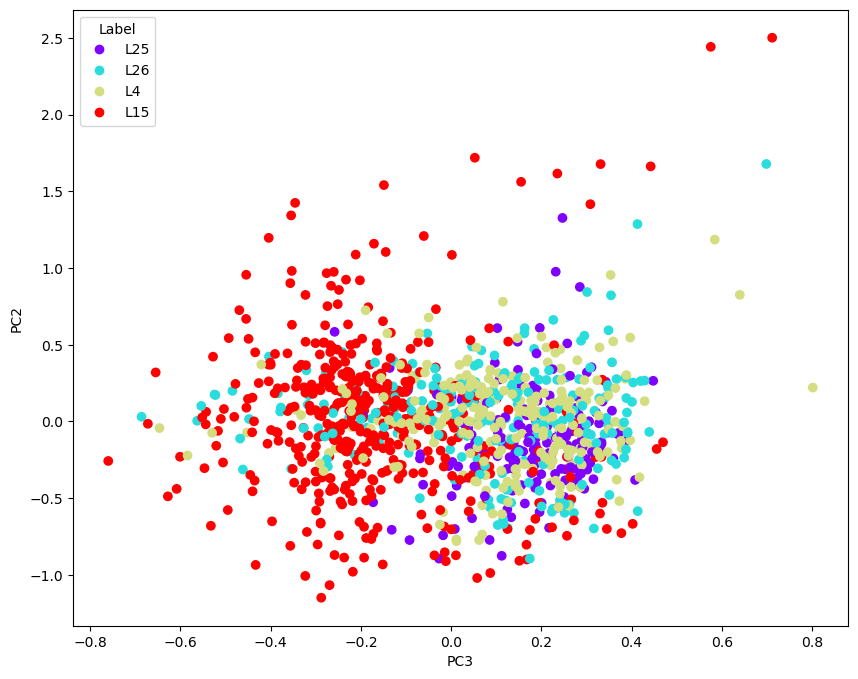

In [19]:
# Create a DataFrame from X_pca with labels for visualization
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df['label'] = y

vis_clust_2D(X_pca_df.iloc[::20, :], pc_to_visualize=(3, 2))

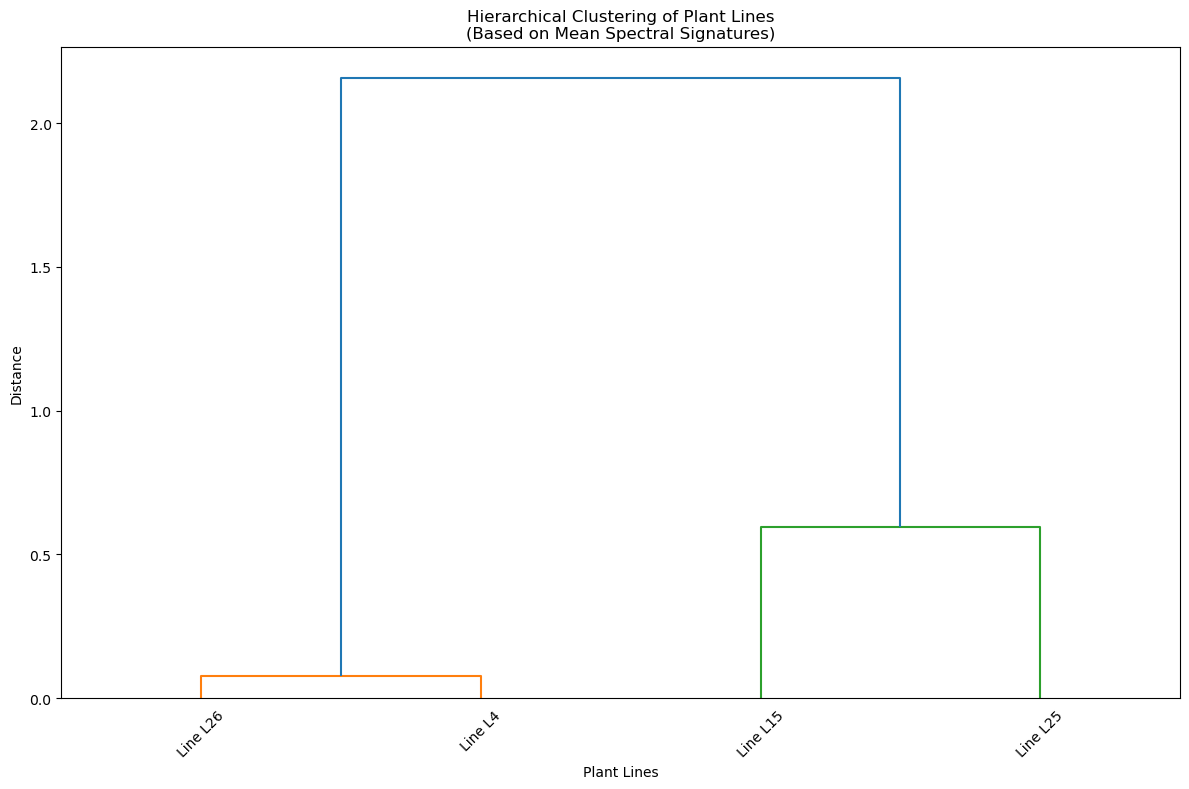

In [20]:
# Hierarchical Clustering Analysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Calculate mean spectra for each label
mean_spectra = []
label_names = []
unique_labels = np.unique(y)
for label in unique_labels:
    mask = y == label
    mean_spectrum = X[mask].mean(axis=0)
    mean_spectra.append(mean_spectrum)
    label_names.append(f'Line {label}')

mean_spectra = np.array(mean_spectra)

# Calculate distance matrix between mean spectra
distances = pdist(mean_spectra, metric='euclidean')
linkage_matrix = linkage(distances, method='ward')

# Create dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=label_names, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical Clustering of Plant Lines\n(Based on Mean Spectral Signatures)')
plt.xlabel('Plant Lines')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()



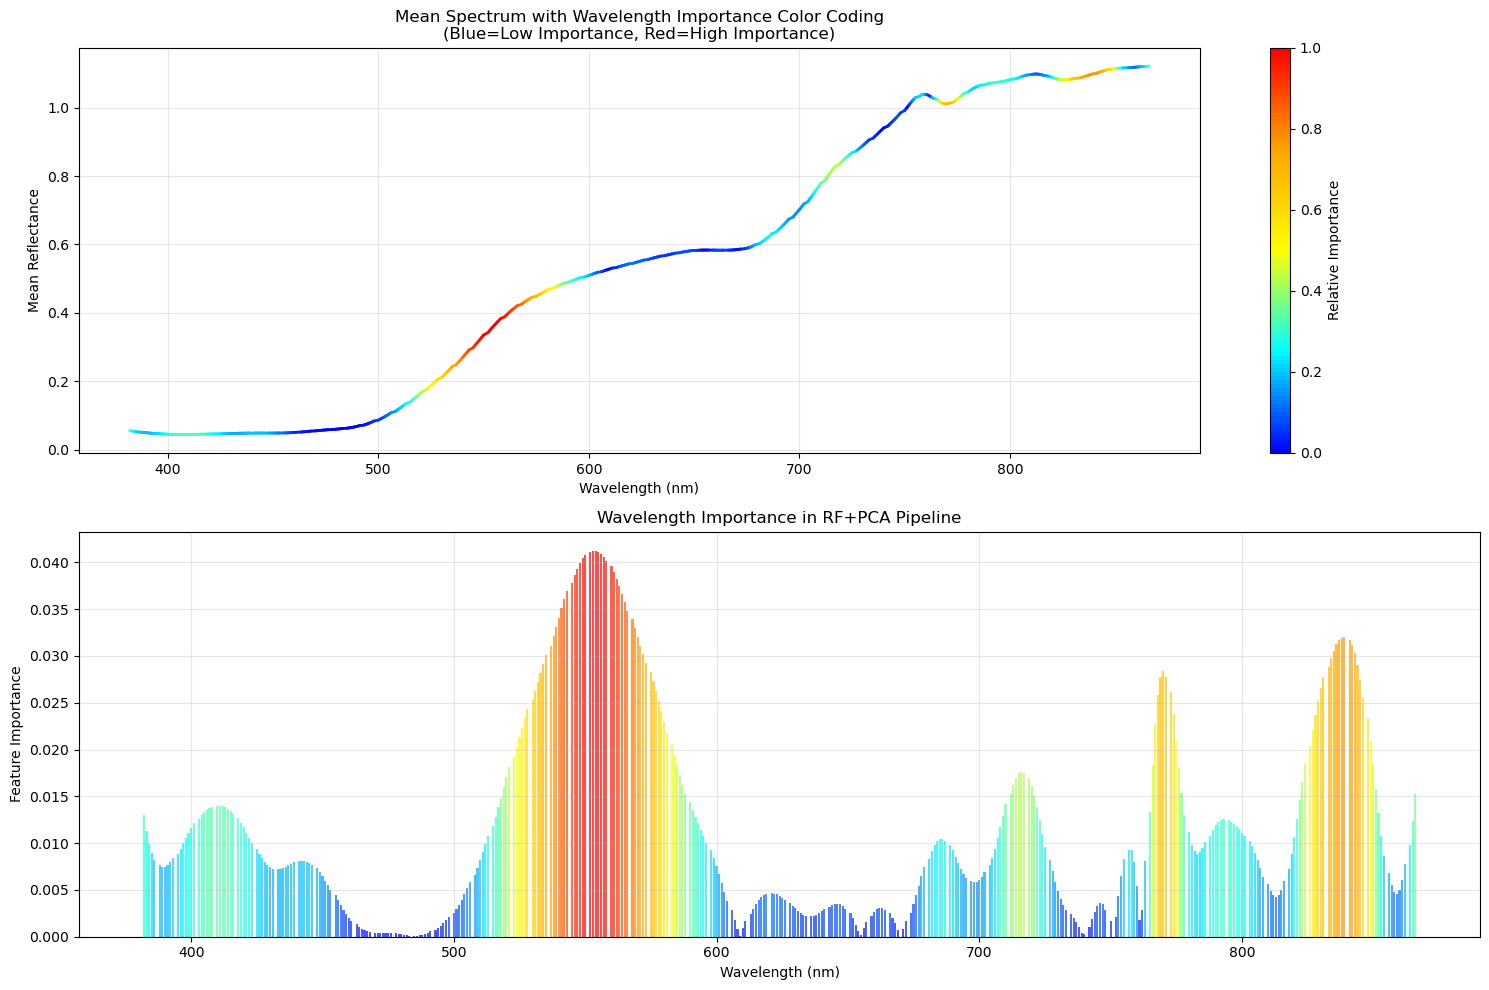


Top 10 most important wavelengths:
 1.  554 nm - Importance: 0.0412
 2.  553 nm - Importance: 0.0412
 3.  555 nm - Importance: 0.0411
 4.  552 nm - Importance: 0.0411
 5.  556 nm - Importance: 0.0409
 6.  550 nm - Importance: 0.0408
 7.  557 nm - Importance: 0.0406
 8.  549 nm - Importance: 0.0404
 9.  558 nm - Importance: 0.0401
10.  548 nm - Importance: 0.0399

PCA Components shape: (40, 421)
RF Feature Importance shape: (40,)
Wavelength Importance shape: (421,)
Number of wavelengths: 421


In [22]:
# Feature Importance Analysis for Wavelengths in RF+PCA Pipeline
from matplotlib.colors import LinearSegmentedColormap

# Get PCA components and RF feature importance
pca_components = pca_component.components_  # Shape: (n_components, n_features)
rf_feature_importance = rf_component.feature_importances_  # Shape: (n_components,)

# Calculate wavelength importance by combining PCA loadings with RF importance
# This gives us the contribution of each original wavelength to the final prediction
wavelength_importance = np.abs(pca_components.T @ rf_feature_importance)

# Normalize importance to 0-1 range for color mapping
wavelength_importance_norm = (wavelength_importance - wavelength_importance.min()) / (wavelength_importance.max() - wavelength_importance.min())

# Get wavelengths from the original data
wavelengths = df.columns[df.columns.map(lambda x: str(x).isdigit())].astype(int).values
# wavelengths = wavelengths[(wavelengths >= 450) & (wavelengths <= 849)]

# Calculate mean spectrum across all samples for visualization
mean_spectrum = X.mean(axis=0)

# Create color map from blue (low importance) to red (high importance)
colors = ['blue', 'cyan', 'yellow', 'orange', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('importance', colors, N=n_bins)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Color-coded spectrum line
for i in range(len(wavelengths)-1):
    color = cmap(wavelength_importance_norm[i])
    ax1.plot(wavelengths[i:i+2], mean_spectrum[i:i+2], color=color, linewidth=2)

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Mean Reflectance')
ax1.set_title('Mean Spectrum with Wavelength Importance Color Coding\n(Blue=Low Importance, Red=High Importance)')
ax1.grid(True, alpha=0.3)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Relative Importance')

# Plot 2: Importance values as bar plot
ax2.bar(wavelengths, wavelength_importance, color=[cmap(x) for x in wavelength_importance_norm], alpha=0.7)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Feature Importance')
ax2.set_title('Wavelength Importance in RF+PCA Pipeline')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top important wavelengths
top_n = 10
top_indices = np.argsort(wavelength_importance)[-top_n:][::-1]
print(f"\nTop {top_n} most important wavelengths:")
for i, idx in enumerate(top_indices):
    print(f"{i+1:2d}. {wavelengths[idx]:4d} nm - Importance: {wavelength_importance[idx]:.4f}")

print(f"\nPCA Components shape: {pca_components.shape}")
print(f"RF Feature Importance shape: {rf_feature_importance.shape}")
print(f"Wavelength Importance shape: {wavelength_importance.shape}")
print(f"Number of wavelengths: {len(wavelengths)}")

# Classification of Processed Images

Apply the trained RF+PCA pipeline to classify masked pixels in processed images and visualize results with colored overlays for each predicted class.

In [ ]:
def classify_processed_images(processed_images, masks, pipeline, repeat=10):
    """
    Classify masked pixels in processed images using trained pipeline.
    
    Parameters:
    -----------
    processed_images : dict
        Dictionary of processed HS images
    masks : dict 
        Dictionary of masks for each image
    pipeline : sklearn.Pipeline
        Trained classification pipeline
    repeat : int
        Repeat factor for visualization
        
    Returns:
    --------
    classification_results : dict
        Dictionary containing classification results for each image
    """
    
    # Get unique labels and assign colors
    unique_labels = np.unique(y_train)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    print(f"Available labels: {unique_labels}")
    print(f"Color mapping: {label_colors}")
    
    classification_results = {}
    
    for image_name, hs_image in processed_images.items():
        print(f"\nProcessing {image_name}...")
        
        # Get corresponding mask
        if image_name in masks:
            mask = masks[image_name]
        else:
            print(f"No mask found for {image_name}, skipping...")
            continue
            
        # Get image data and reshape
        img_data = hs_image.img  # Shape: (height, width, bands)
        height, width, n_bands = img_data.shape
        
        # Create mask for valid pixels (where mask == 1)
        if len(mask.shape) == 3:
            mask_2d = mask[:, :, 0]  # Convert to 2D if needed
        else:
            mask_2d = mask
            
        valid_pixels = mask_2d == 1
        n_valid_pixels = np.sum(valid_pixels)
        
        if n_valid_pixels == 0:
            print(f"No valid pixels in {image_name}")
            continue
            
        print(f"Found {n_valid_pixels} valid pixels to classify")
        
        # Extract spectra for masked pixels
        masked_spectra = img_data[valid_pixels]  # Shape: (n_valid_pixels, n_bands)
        
        # Filter to wavelength range used in training (350-849 nm)
        wavelength_mask = (np.array(hs_image.ind) >= 450) & (np.array(hs_image.ind) <= 849)
        masked_spectra_filtered = masked_spectra[:, wavelength_mask]
        
        print(f"Spectral data shape: {masked_spectra_filtered.shape}")
        
        # Predict using pipeline
        predictions = pipeline.predict(masked_spectra_filtered)
        prediction_probs = pipeline.predict_proba(masked_spectra_filtered)
        
        print(f"Predictions shape: {predictions.shape}")
        print(f"Unique predictions: {np.unique(predictions, return_counts=True)}")
        
        # Create classification map - use object dtype to handle string labels
        classification_map = np.full((height, width), '', dtype=object)
        classification_map[valid_pixels] = predictions
        
        # Create probability maps for each class
        prob_maps = {}
        for i, label in enumerate(unique_labels):
            prob_map = np.zeros((height, width))
            prob_map[valid_pixels] = prediction_probs[:, i]
            prob_maps[label] = prob_map
        
        # Store results
        classification_results[image_name] = {
            'classification_map': classification_map,
            'probability_maps': prob_maps,
            'predictions': predictions,
            'prediction_probs': prediction_probs,
            'valid_pixels': valid_pixels,
            'n_valid_pixels': n_valid_pixels
        }
        
        # Print basic statistics
        print(f"Classification Statistics for {image_name}:")
        for label in unique_labels:
            count = np.sum(classification_map == label)
            percentage = (count / np.sum(valid_pixels)) * 100 if np.sum(valid_pixels) > 0 else 0
            print(f"  Line {label}: {count:4d} pixels ({percentage:5.1f}%)")
        print()
    
    # Show simplified grid visualization at the end
    print("Creating classification overview...")
    visualize_classification_grid(classification_results, processed_images, label_colors, unique_labels, repeat)
    
    return classification_results, label_colors

# Run classification (uncomment if you want to run again)
# classification_results, label_colors = classify_processed_images(processed_images, masks, pipeline, repeat=10)

In [26]:
def visualize_classification_grid(classification_results, processed_images, label_colors, unique_labels, repeat=10):
    """
    Simplified visualization showing only full classification overlays in a grid.
    
    Parameters:
    -----------
    classification_results : dict
        Dictionary containing classification results for each image
    processed_images : dict
        Dictionary of processed HS images
    label_colors : dict
        Mapping of labels to colors
    unique_labels : numpy.ndarray
        Array of unique class labels
    repeat : int
        Repeat factor for visualization
    """
    
    n_images = len(classification_results)
    
    # Calculate grid dimensions (try to make it roughly square)
    cols = int(np.ceil(np.sqrt(n_images)))
    rows = int(np.ceil(n_images / cols))
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    fig.suptitle('Classification Results - Full Overlays', fontsize=16, fontweight='bold')
    
    # Handle single row or column case
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Plot each image
    for idx, (image_name, results) in enumerate(classification_results.items()):
        if idx >= len(axes):
            break
            
        hs_image = processed_images[image_name]
        classification_map = results['classification_map']
        
        # Get RGB representation
        orig_rgb = get_rgb_sample(hs_image, normalize=False, correct=False) * 2
        orig_rgb = np.clip(orig_rgb, 0, 1)  # Clip to valid range
        
        # Repeat for visualization
        rgb_rep = np.repeat(orig_rgb, repeat, axis=0)
        classification_rep = np.repeat(classification_map, repeat, axis=0)
        
        # Show original image
        axes[idx].imshow(rgb_rep)
        
        # Create multi-class overlay
        full_overlay = np.full((classification_rep.shape[0], classification_rep.shape[1], 3), np.nan)
        for label in unique_labels:
            class_mask = classification_rep == label
            if np.any(class_mask):
                color = label_colors[label]
                full_overlay[class_mask, :] = color[:3]  # Use RGB components
        
        # Apply overlay
        axes[idx].imshow(full_overlay, alpha=0.7)
        
        # Clean up image name for title
        clean_name = image_name.replace('-VNIR-Data.hdr', '').replace('-', ' ')
        axes[idx].set_title(clean_name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        
        # Add pixel count text
        total_pixels = np.sum(results['valid_pixels'])
        axes[idx].text(0.02, 0.98, f'{total_pixels} pixels', 
                      transform=axes[idx].transAxes, 
                      verticalalignment='top',
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                      fontsize=10)
    
    # Hide unused subplots
    for idx in range(len(classification_results), len(axes)):
        axes[idx].set_visible(False)
    
    # Create legend
    legend_elements = []
    for label in unique_labels:
        color = label_colors[label]
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color[:3], 
                                           label=f'Line {label}'))
    
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=len(unique_labels))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # Print summary statistics
    print("\nClassification Summary:")
    print("=" * 60)
    for image_name, results in classification_results.items():
        classification_map = results['classification_map']
        valid_pixels = results['valid_pixels']
        total_pixels = np.sum(valid_pixels)
        
        # Find dominant class
        unique_preds, counts = np.unique(classification_map[valid_pixels], return_counts=True)
        dominant_idx = np.argmax(counts)
        dominant_class = unique_preds[dominant_idx]
        dominant_percentage = (counts[dominant_idx] / total_pixels) * 100
        
        clean_name = image_name.replace('-VNIR-Data.hdr', '')
        print(f"{clean_name:20s}: {total_pixels:4d} pixels, {dominant_percentage:5.1f}% {dominant_class}")

# Run the simplified visualization
visualize_classification_grid(classification_results, processed_images, label_colors, unique_labels, repeat=10)

NameError: name 'classification_results' is not defined